<a href="https://colab.research.google.com/github/hasanahaffendy/STQD6234-DataManagement/blob/main/DataManagement_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import numpy as np
from scipy.interpolate import make_interp_spline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**PIG Latin Code**


1.   Load the airline data with necessary columns

AIRLINE_DATA = LOAD '/user/maria_dev/airplane/2008.csv' USING PigStorage(',')
    AS (
        Year:int,
        Month:int,
        DayofMonth:int,
        DayOfWeek:int,
        DepTime:int,
        CRSDepTime:int,
        ArrTime:int,
        CRSArrTime:int,
        UniqueCarrier:chararray,
        FlightNum:int,
        TailNum:chararray,
        ActualElapsedTime:int,
        CRSElapsedTime:int,
        AirTime:int,
        ArrDelay:int,
        DepDelay:int,
        Origin:chararray,
        Dest:chararray,
        Distance:int,
        TaxiIn:int,
        TaxiOut:int,
        Cancelled:int,
        CancellationCode:chararray,
        Diverted:int,
        CarrierDelay:double,
        WeatherDelay:double,
        NASDelay:double,
        SecurityDelay:double,
        LateAircraftDelay:double
    );

2.   Load the airport data

AIRPORTS = LOAD '/user/maria_dev/airplane/airports.csv' USING PigStorage(',')
    AS (iata:chararray, airport:chararray, city:chararray, state:chararray, country:chararray, lat:double, long:double);


3.   Load the carrier's data

CARRIERS = LOAD '/user/maria_dev/airplane/carriers.csv' USING PigStorage(',')
    AS (code:chararray, description:chararray);

4.   Load the plane data

PLANES = LOAD '/user/maria_dev/airplane/plane-data.csv' USING PigStorage(',')
    AS (tailnum:chararray, type:chararray, manufacturer:chararray, issue_date:chararray, model:chararray, status:chararray, aircraft_type:chararray, engine_type:chararray, year:int);


In [11]:
avg_delay_by_hour_path = '/content/drive/MyDrive/Airplane/avg_delay_by_hour'
avg_delay_by_hour = pd.read_csv(avg_delay_by_hour_path, header=None, names=['Hour', 'AvgDelay'])

avg_delay_by_day_path = '/content/drive/MyDrive/Airplane/avg_delay_by_day'
avg_delay_by_day = pd.read_csv(avg_delay_by_day_path, header=None, names=['DayOfWeek', 'AvgDelay'])

avg_delay_by_month_path = '/content/drive/MyDrive/Airplane/avg_delay_by_month'
avg_delay_by_month = pd.read_csv(avg_delay_by_month_path, header=None, names=['Month', 'AvgDelay'])

avg_delays_path = '/content/drive/MyDrive/Airplane/avg_delays'

cancellation_factors_path = '/content/drive/MyDrive/Airplane/cancellation_factors_labeled'
cancellation_factors = pd.read_csv(cancellation_factors_path, header=None, names=['CancellationCode', 'CancellationCounts'])

ordered_issues_path = '/content/drive/MyDrive/Airplane/ordered_issues'
ordered_issues = pd.read_csv(ordered_issues_path, header=None, names=['FlightNum','DelayCount', 'TotalDelay', 'CancelCount'])

**PIG Latin Code**


1.   Extract the hour from the departure time

HOUR_DELAY = FOREACH AIRLINE_DATA GENERATE (int)(DepTime / 100) as Hour, ArrDelay;

2.   Check valid hours (0-23) only

VALID_HOUR_DELAY = FILTER HOUR_DELAY BY (Hour >= 0 AND Hour <= 23);

3.   Group by hour

GROUPED_BY_HOUR = GROUP VALID_HOUR_DELAY BY Hour;

4.   Calculate the average delay per hour

AVG_DELAY_BY_HOUR = FOREACH GROUPED_BY_HOUR GENERATE group as Hour, AVG(VALID_HOUR_DELAY.ArrDelay) as AvgDelay;

5.   Output result

DUMP ORDERED_AVG_DELAY_BY_HOUR;

6.   Store the results

STORE ORDERED_AVG_DELAY_BY_HOUR INTO '/user/maria_dev/airplane/avg_delay_by_hour' USING PigStorage(',');


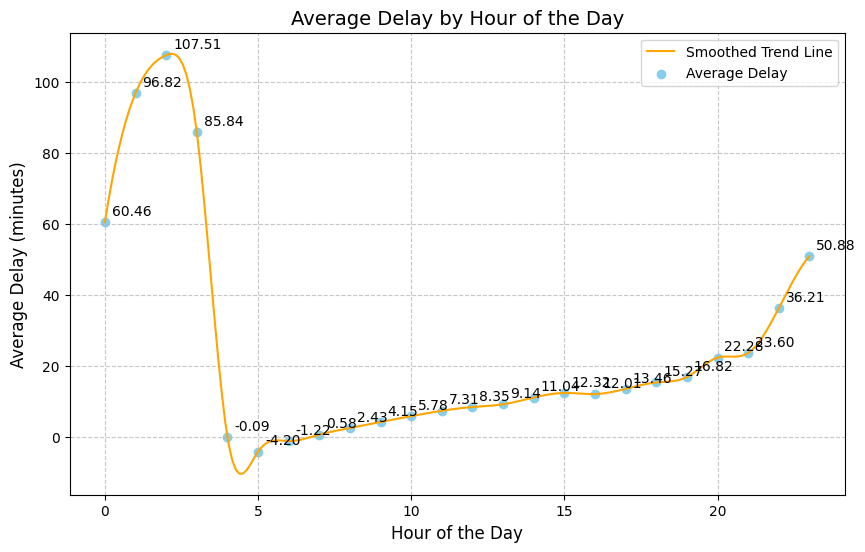

In [5]:
# Smooth the data for a more visually appealing trend line
spl = make_interp_spline(avg_delay_by_hour['Hour'], avg_delay_by_hour['AvgDelay'], k=3)
hours_smooth = np.linspace(avg_delay_by_hour['Hour'].min(), avg_delay_by_hour['Hour'].max(), 200)
avg_delay_smooth = spl(hours_smooth)

# Plot the data with enhancements
plt.figure(figsize=(10, 6))

# Plot the smoothed trend line
plt.plot(hours_smooth, avg_delay_smooth, color='orange', linestyle='-', label='Smoothed Trend Line')

# Plot the data points with markers
plt.scatter(avg_delay_by_hour['Hour'], avg_delay_by_hour['AvgDelay'], marker='o', color='skyblue', label='Average Delay')

# Add data point annotations
for i, txt in enumerate(avg_delay_by_hour['AvgDelay']):
    plt.annotate(f'{txt:.2f}', (avg_delay_by_hour['Hour'][i], avg_delay_by_hour['AvgDelay'][i]), fontsize=10, xytext=(5, 5), textcoords='offset points')

# Add title and labels
plt.title('Average Delay by Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Save the plot as a PNG file
plt.savefig('avg_delay_by_hour_enhanced.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

The plot illustrates the variation in average flight delays across different hours of the day as follows:

*   **Hour 0 (midnight)**: Flights departing at midnight have an average delay of approximately 60.46 minutes.

*   **Hour 1 (1:00 AM)**: Flights departing at 1:00 AM have an average delay of around 96.82 minutes.

*   **Hour 2 (2:00 AM)**: Flights departing at 2:00 AM have an average delay of approximately 107.51 minutes.

*   **Hour 3 (3:00 AM)**: Flights departing at 3:00 AM have an average delay of about 85.84 minutes.

*   **Hour 4 (4:00 AM)**: Surprisingly, flights departing at 4:00 AM have a negative average delay of approximately -0.09 minutes. This could indicate that, on average, flights departing at this hour arrive earlier than scheduled.

*   **Hour 5 (5:00 AM)** to **Hour 6 (6:00 AM)**: Flights departing during these hours also have harmful average delays, indicating that they tend to arrive earlier than scheduled.

*   **Hour 7 (7:00 AM)**: Flights departing at 7:00 AM have a slight average delay of about 0.58 minutes.

*   **Hour 8 (8:00 AM)** onwards: The average delay gradually increases, reaching its peak at **Hour 23 (11:00 PM)**, with an average delay of approximately 50.88 minutes.

This output provides valuable insights into the variation of flight delays throughout the day, which can be crucial for airline operations and passenger planning.



**PIG Latin Code**


1.   Group by day of the week

GROUPED_BY_DAY = GROUP AIRLINE_DATA BY DayOfWeek;

2.   Calculate the average delay per day

AVG_DELAY_BY_DAY = FOREACH GROUPED_BY_DAY GENERATE group as DayOfWeek, AVG(AIRLINE_DATA.ArrDelay) as AvgDelay;

3.   Order by day of the week

ORDERED_AVG_DELAY_BY_DAY = ORDER AVG_DELAY_BY_DAY BY DayOfWeek ASC;

4.   Output the ordered results

DUMP avg_delay_by_day;

5.   Store the results

STORE ORDERED_AVG_DELAY_BY_DAY INTO '/user/maria_dev/airplane/avg_delay_by_day'



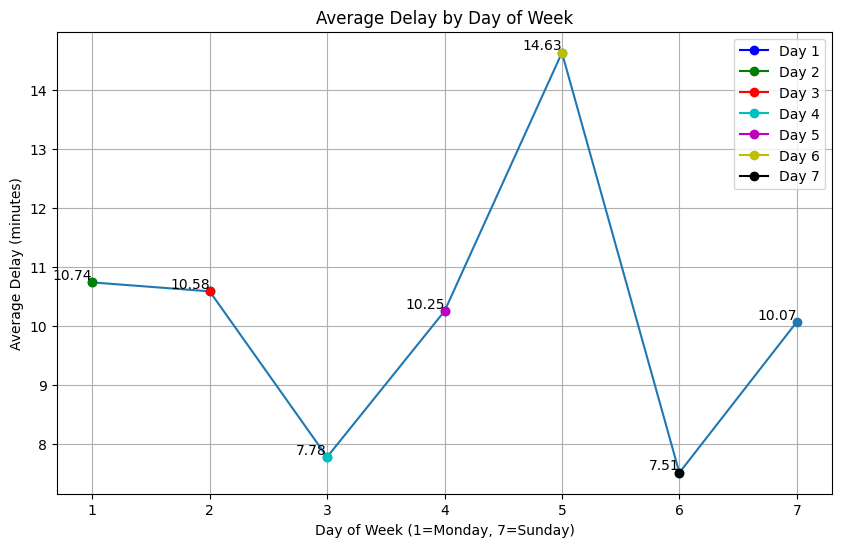

In [29]:
import matplotlib.pyplot as plt

# Your data
plt.figure(figsize=(10, 6))
plt.plot(avg_delay_by_day['DayOfWeek'], avg_delay_by_day['AvgDelay'], marker='o', linestyle='-')
plt.xlabel('Day of Week (1=Monday, 7=Sunday)')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Delay by Day of Week')
plt.xticks(range(1, 8))
plt.grid(True)

# Enhancements
# Adding color variation
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, color in zip(range(7), colors):
    plt.plot(avg_delay_by_day['DayOfWeek'][i], avg_delay_by_day['AvgDelay'][i], marker='o', linestyle='-', color=color, label=f'Day {i+1}')

# Adding data labels
for x, y, label in zip(avg_delay_by_day['DayOfWeek'], avg_delay_by_day['AvgDelay'], avg_delay_by_day['AvgDelay']):
    plt.text(x, y, f'{label:.2f}', ha='right', va='bottom')

plt.legend(loc='upper right')
plt.show()

The plot presents the average delay for flights on each day of the week as follows:

*   **Day 1 (Monday)**: The average delay for flights on Monday is approximately 10.74 minutes.

*   **Day 2 (Tuesday)**: The average delay for flights on Tuesday is approximately 10.58 minutes.

*   **Day 3 (Wednesday)**: The average delay for flights on Wednesday is approximately 7.78 minutes.

*   **Day 4 (Thursday)**: The average delay for flights on Thursday is approximately 10.25 minutes.

*   **Day 5 (Friday)**: The average Friday flight delay is approximately 14.63 minutes.

*   **Day 6 (Saturday)**: The average delay for flights on Saturday is approximately 7.51 minutes.

*   **Day 7 (Sunday)**: The average delay for flights on Sunday is approximately 10.07 minutes.

This analysis provides valuable insights into the average delay patterns for each day of the week. It highlights that Friday experiences the highest average delay, while Wednesday and Saturday have relatively lower average delays. Understanding these patterns can assist airlines and travelers in planning their journeys more effectively and anticipating potential delays on specific days of the week.



**PIG Latin Code**


1.   Group by month

GROUPED_BY_MONTH = GROUP AIRLINE_DATA BY Month;

2.   Calculate the average delay per month

AVG_DELAY_BY_MONTH = FOREACH GROUPED_BY_MONTH GENERATE group as Month, AVG(AIRLINE_DATA.ArrDelay) as AvgDelay;

3.   Order by month

ORDERED_AVG_DELAY_BY_MONTH = ORDER AVG_DELAY_BY_MONTH BY Month ASC;

4.   Output the ordered results

DUMP ORDERED_AVG_DELAY_BY_MONTH;

5.   Store the results

STORE ORDERED_AVG_DELAY_BY_MONTH INTO '/user/maria_dev/airplane/ORDERED_AVG_DELAY_BY_MONTH' USING PigStorage(',');



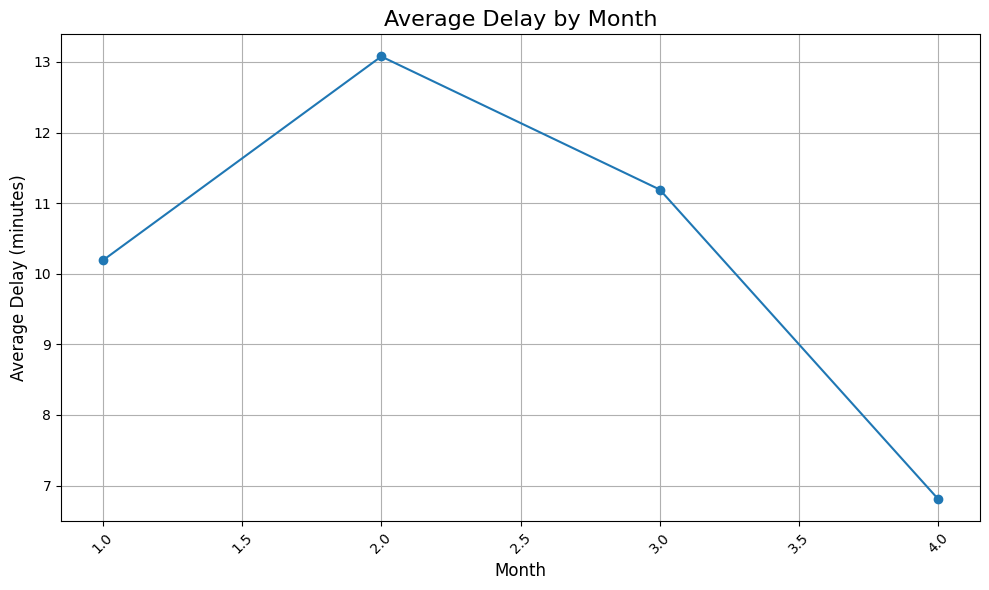

In [21]:
# Plot average delay by month
plt.figure(figsize=(10, 6))

# Smooth line plot with marker
plt.plot(avg_delay_by_month['Month'], avg_delay_by_month['AvgDelay'], marker='o', linestyle='-')

# Title with centered alignment
plt.title('Average Delay by Month', fontsize=16, loc='center')

# Labels and axis
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)

# Gridlines for better readability
plt.grid(True)

# Adjust x-axis ticks and rotate labels
plt.xticks(rotation=45, fontsize=10)

# Save figure with improved resolution
plt.savefig('avg_delay_by_month.png', dpi=300)

# Show plot
plt.tight_layout()
plt.show()

The plot illustrates the average delay for different months as follows:

*   **Month 1**: The average delay is approximately 10.19 minutes.
*  **Month 2**: The average delay is approximately 13.08 minutes.
*   **Month 3**: The average delay is approximately 11.19 minutes.
*   **Month 4**: The average delay is approximately 6.81 minutes.

This analysis indicates that month four experiences the lowest average delay, while month 2 exhibits the highest average delay among the listed months. These insights provide valuable information for understanding the variation in delays across different months, enabling stakeholders to implement targeted strategies to address delays and improve overall operational efficiency.


**PIG Latin Code**


1.   Filter for non-cancelled flights

ontime_flights = FILTER AIRLINE_DATA BY Cancelled == 0;

2.   Calculate average delay for each factor

GROUPED_BY_MONTH = GROUP ON_TIME_FLIGHTS BY Month;

avg_delays = FOREACH (GROUP ontime_flights ALL)
    GENERATE
        'CarrierDelay' AS DelayType1,
        AVG(ontime_flights.CarrierDelay) AS AvgCarrierDelay,
        'WeatherDelay' AS DelayType2,
        AVG(ontime_flights.WeatherDelay) AS AvgWeatherDelay,
        'NASDelay' AS DelayType3,
        AVG(ontime_flights.NASDelay) AS AvgNASDelay,
        'SecurityDelay' AS DelayType4,
        AVG(ontime_flights.SecurityDelay) AS AvgSecurityDelay,
        'LateAircraftDelay' AS DelayType5,
        AVG(ontime_flights.LateAircraftDelay) AS AvgLateAircraftDelay;

3.   Output the average delays with labels

DUMP avg_delays;

4.   Store the results

STORE avg_delays INTO '/user/maria_dev/airplane/avg_delays' USING PigStorage(',');




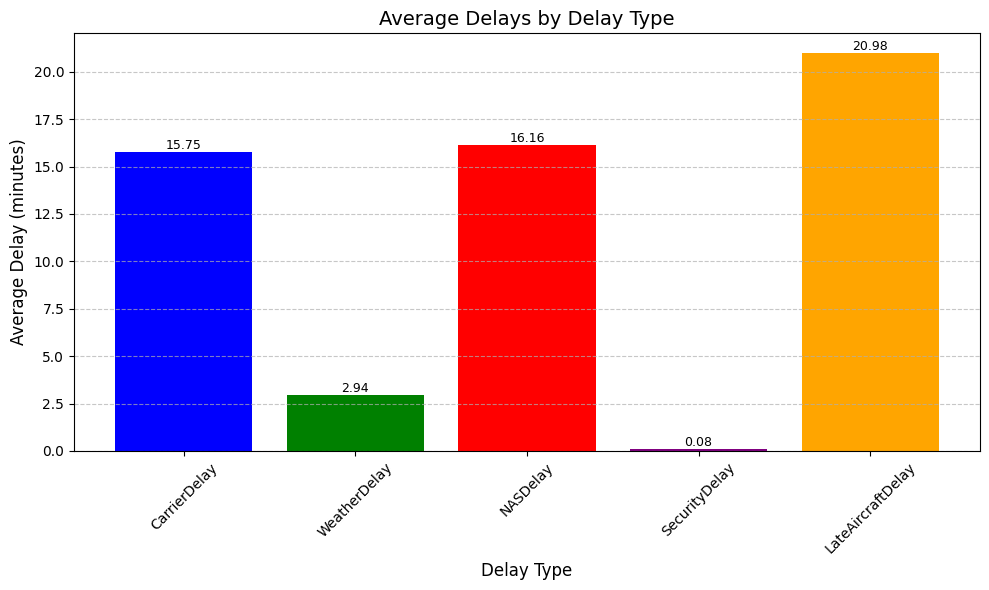

In [12]:
# Read the data from the file into a DataFrame
with open(avg_delays_path, 'r') as file:
    data = file.read()

# Convert the data to a dictionary
data_list = data.split(',')
data_dict = {data_list[i]: float(data_list[i+1]) for i in range(0, len(data_list), 2)}

# Create DataFrame from the dictionary
avg_delays = pd.DataFrame(list(data_dict.items()), columns=['DelayType', 'AvgDelay'])

# Plotting the data with enhancements
plt.figure(figsize=(10, 6))

# Define colors for each delay type
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot the bar chart
bars = plt.bar(avg_delays['DelayType'], avg_delays['AvgDelay'], color=colors)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=9)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add title and labels
plt.title('Average Delays by Delay Type', fontsize=14)
plt.xlabel('Delay Type', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


The bar graph depicts the average delay attributed to different factors influencing flight delays. Here's a breakdown of each component:

1.   **CarrierDelay:**
This category encompasses delays related to carrier-specific issues like maintenance, crew scheduling, or aircraft cleaning. On average, carrier delays amount to approximately 15.75 minutes.

2.   **WeatherDelay:**
Weather-related factors such as thunderstorms, fog, or lightning contribute to delays in this category. The average weather delay stands at about 2.94 minutes.

3.   **NASDelay (National Airspace System):**
Delays associated with the National Airspace System (NAS), including air traffic control, airport operations, and airspace congestion, are accounted for here. On average, NAS delays account for around 16.16 minutes.

4.   **LateAircraftDelay:**
This delay type signifies the average delay resulting from the late arrival of the aircraft from its preceding flight. Late aircraft delays contribute the most to overall delays, with an average delay of about 20.98 minutes.

These insights into the average delays attributed to various factors enable airlines and airport authorities to pinpoint areas for improvement and devise strategies to mitigate delays caused by each factor.

**PIG Latin Code**


1.   Filter for cancelled flights

cancelled_flights = FILTER AIRLINE_DATA BY Cancelled == 1;

2.   Group cancelled flights by CancellationCode and count occurrences

cancellation_counts = GROUP cancelled_flights BY CancellationCode;

3.   Calculate the count of cancelled flights for each cancellation code

cancellation_factors = FOREACH cancellation_counts GENERATE
    group AS CancellationCode,
    COUNT(cancelled_flights) AS CancellationCount;

4.   Replace the cancellation codes with descriptions

cancellation_factors_labeled = FOREACH cancellation_factors GENERATE
    (CASE
        WHEN CancellationCode == 'A' THEN 'carrier'
        WHEN CancellationCode == 'B' THEN 'weather'
        WHEN CancellationCode == 'C' THEN 'NAS'
        WHEN CancellationCode == 'D' THEN 'security'
        ELSE 'Unknown'
    END) AS CancellationReason,
    CancellationCount;



5.   Output the cancellation statistics with descriptive labels

DESCRIBE cancellation_factors_labeled;

DUMP cancellation_factors_labeled;

STORE cancellation_factors_labeled INTO '/user/maria_dev/airplane/cancellation_factors_labeled' USING PigStorage(',');



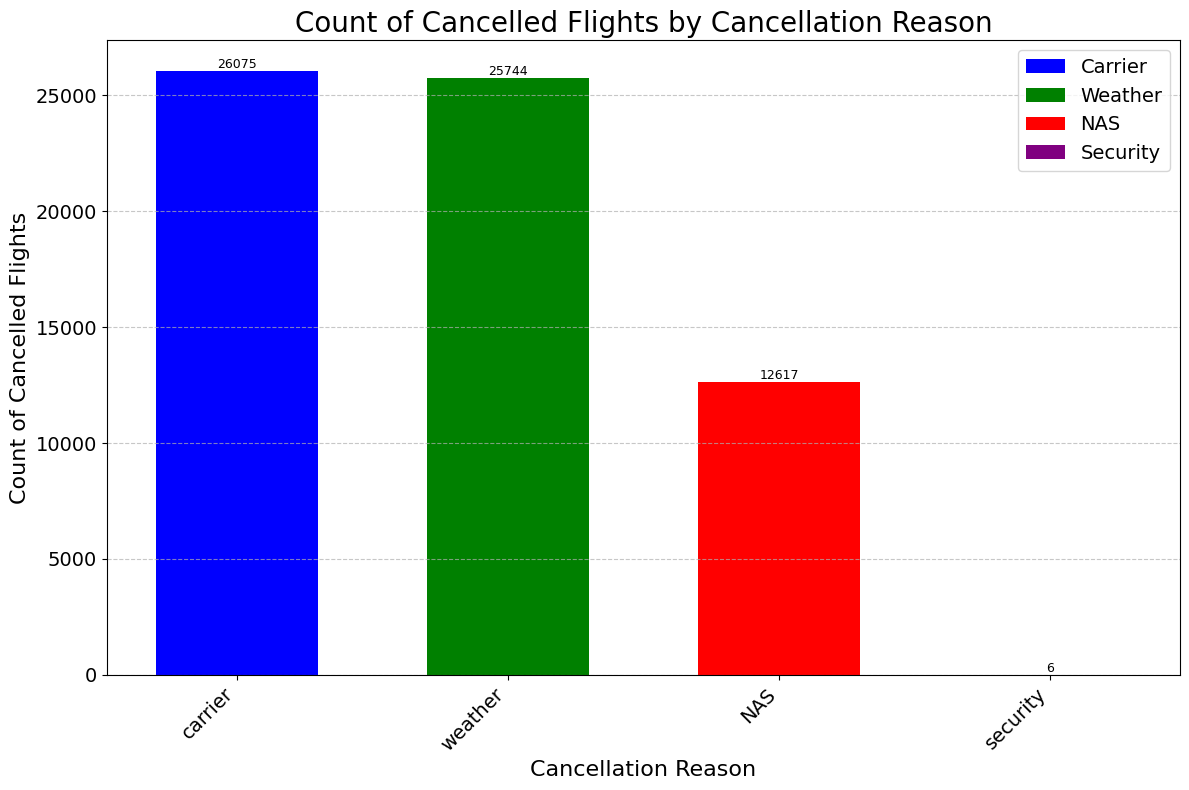

In [18]:
# Plotting with further enhancements
plt.figure(figsize=(12, 8))  # Increase figure size

# Define colors and labels for each cancellation reason
colors = ['blue', 'green', 'red', 'purple']
labels = ['Carrier', 'Weather', 'NAS', 'Security']

# Plot the bar chart with improved aesthetics
bars = plt.bar(cancellation_factors['CancellationCode'], cancellation_factors['CancellationCounts'], color=colors, width=0.6)

# Add data labels on top of each bar with custom formatting
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', va='bottom', ha='center', fontsize=9)

# Add legend
plt.legend(bars, labels, loc='upper right', fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add title and labels with larger fonts
plt.title('Count of Cancelled Flights by Cancellation Reason', fontsize=20)
plt.xlabel('Cancellation Reason', fontsize=16)
plt.ylabel('Count of Cancelled Flights', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, ha='right')

# Adjust y-axis labels font size
plt.yticks(fontsize=14)

# Ensure y-axis starts from 0
plt.ylim(0)

# Show plot
plt.tight_layout()
plt.show()

The bar graph provides a breakdown of flight cancellations based on different factors:

**Carrier (26075):**
This indicates that 26,075 flights were cancelled due to issues related to the airline carrier. These issues could encompass maintenance problems, crew issues, or operational disruptions within the airline's domain.

**Weather (25744):**
This signifies that 25,744 flights were cancelled due to adverse weather conditions. Weather plays a significant role in flight operations, with common causes for cancellations including severe storms, snow and ice, fog, or high winds.

**NAS (National Airspace System) (12617):**
This suggests that 12,617 flights were cancelled due to issues within the National Airspace System (NAS). This encompasses air traffic control delays, airport operations issues, heavy traffic volume, or any systemic problems within the national airspace Infrastructure.

**Security (6):**
This indicates that only six flights were cancelled due to security reasons. While security is crucial, flight cancellations are relatively rare solely due to security concerns. These reasons could involve security threats, breaches at the airport, or alerts triggering cancellations.

This breakdown offers insights into the diverse factors contributing to flight cancellations and highlighting the relative frequencies of each category.





**PIG Latin Code**


1.   Join airline data with planes data on TailNum

JOINED_AIRLINE_PLANES = JOIN AIRLINE_DATA BY TailNum, PLANES BY tailnum;

2.   Filter out cancelled flights

cancelled_flights = FILTER JOINED_AIRLINE_PLANES BY Cancelled == 1;

3.   Group by FlightNum to count cancellations

cancelled_flight_count = FOREACH (GROUP cancelled_flights BY FlightNum)
                         GENERATE group AS FlightNum, COUNT(cancelled_flights) AS CancelCount;

4.   Filter out delayed flights

delayed_flights = FILTER JOINED_AIRLINE_PLANES BY ArrDelay > 0;

5.   Group by FlightNum to sum delays and count delayed flights

delayed_flight_count = FOREACH (GROUP delayed_flights BY FlightNum)
                       GENERATE group AS FlightNum, COUNT(delayed_flights) AS DelayCount,
                                SUM(delayed_flights.ArrDelay) AS TotalDelay;



6.   Join delayed and cancelled counts

flight_issues = JOIN delayed_flight_count BY FlightNum LEFT OUTER, cancelled_flight_count BY FlightNum;

7.   Replace null val-- Join airline data with planes data on TailNum

JOINED_AIRLINE_PLANES = JOIN AIRLINE_DATA BY TailNum, PLANES BY tailnum;


8.   Filter out cancelled flights

cancelled_flights = FILTER JOINED_AIRLINE_PLANES BY Cancelled == 1;

9.   Group by FlightNum to count cancellations

cancelled_flight_count = FOREACH (GROUP cancelled_flights BY FlightNum)
                         GENERATE group AS FlightNum, COUNT(cancelled_flights) AS CancelCount;



10.   Filter out delayed flights

delayed_flights = FILTER JOINED_AIRLINE_PLANES BY ArrDelay > 0;

11.   Group by FlightNum to sum delays and count delayed flights

delayed_flight_count = FOREACH (GROUP delayed_flights BY FlightNum)
                       GENERATE group AS FlightNum, COUNT(delayed_flights) AS DelayCount,
                                SUM(delayed_flights.ArrDelay) AS TotalDelay;



12.   Join delayed and cancelled counts

flight_issues = JOIN delayed_flight_count BY FlightNum LEFT OUTER, cancelled_flight_count BY FlightNum;

13.   Replace null values with 0 for flights without cancellations

flight_issues_cleaned = FOREACH flight_issues GENERATE delayed_flight_count::FlightNum AS FlightNum,
                        DelayCount, TotalDelay,
                        (cancelled_flight_count::CancelCount IS NULL ? 0 : cancelled_flight_count::CancelCount) AS CancelCount;



14.   Order by most frequent and significant delays and cancellations

ordered_issues = ORDER flight_issues_cleaned BY DelayCount DESC, TotalDelay DESC, CancelCount DESC;

15.   Show and Store Result

DUMP ordered_issues;

STORE ordered_issues INTO '/user/maria_dev/airplane/ordered_issues' USING PigStorage(',');














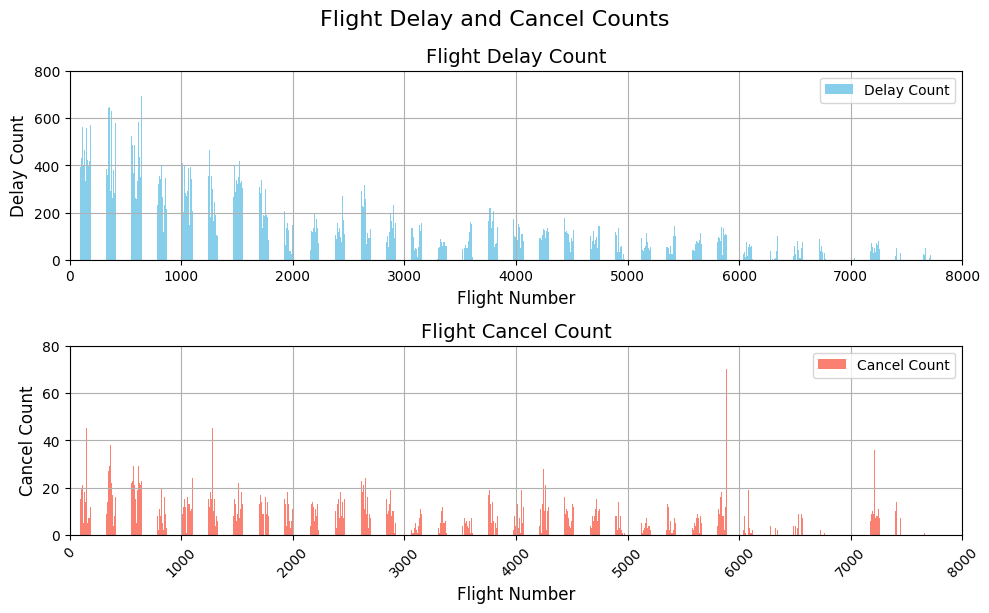

In [26]:
# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for Delay Count
plt.subplot(2, 1, 1)
delay_bars = plt.bar(ordered_issues['FlightNum'], ordered_issues['DelayCount'], color='skyblue', label='Delay Count', width=0.4)
plt.xlabel('Flight Number', fontsize=12)
plt.ylabel('Delay Count', fontsize=12)
plt.title('Flight Delay Count', fontsize=14)
plt.grid(True)  # Add grid lines
plt.legend()  # Add legend for delay count

# Set y-axis limit for delay count
plt.ylim(0, 800)

# Adjust X-axis Limits
plt.xlim(0, 8000)  # Set x-axis limit to 8000

# Bar plot for Cancel Count
plt.subplot(2, 1, 2)
cancel_bars = plt.bar(ordered_issues['FlightNum'], ordered_issues['CancelCount'], color='salmon', label='Cancel Count', width=0.4)
plt.xlabel('Flight Number', fontsize=12)
plt.ylabel('Cancel Count', fontsize=12)
plt.title('Flight Cancel Count', fontsize=14)
plt.grid(True)  # Add grid lines
plt.legend()  # Add legend for cancel count

# Adjust Y-axis Range for Cancel Count
plt.ylim(0, 80)  # Set y-axis limit to less than 100 for cancel count

# Adjust X-axis Limits
plt.xlim(0, 8000)  # Set x-axis limit to 8000

# Adding Super Title
plt.suptitle('Flight Delay and Cancel Counts', fontsize=16, ha='center')

# Adjust layout to prevent overlap of labels
plt.tight_layout()

# Rotate tick labels
plt.xticks(rotation=45)

plt.show()

The graph illustrates pronounced disparities in flight delays across various flight numbers. Notably, flights numbered from 0 to 1000 experience the most substantial delay counts, with instances ranging between 300 to 700 delays. For flight numbers 1001 to 2000, delays typically range from 200 to 400. Meanwhile, flight numbers between 2001 and 3000 encounter delay counts between 200 and 300, while the remainder experience counts below 200.

Conversely, flight cancellations appear infrequent, with minimal visibility of cancel count bars. Noteworthy is the higher cancel count observed for flight numbers 5750 to 6000, exceeding 60 cancellations. Additionally, flight numbers 0 to 250, 1200 to 1400, and those around 7250 to 7000 also exhibit elevated cancellation counts, surpassing 40.

These observations suggest that while delays vary significantly across flight numbers, cancellations remain relatively rare, with most flights proceeding as scheduled.